In [34]:
import pandas as pd
import plotly.express as px
import json
import networkx as nx
import matplotlib.pyplot as plt
import copy

In [35]:
# Read /Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_Nodes.csv
nodes_df = pd.read_csv('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_Nodes.csv', delimiter=';')

# Drop the following columns: param, uncertainty, method, tags
nodes_df = nodes_df.drop(columns=['param', 'uncertainty', 'method', 'tags'])

In [36]:
# Read /Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_PipeSegments.csv
pipe_segments_df = pd.read_csv('/Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_PipeSegments.csv', delimiter=';')

# Split the 'param' column into separate columns
pipe_segments_df['param'] = pipe_segments_df['param'].apply(lambda x: json.loads(x.replace("'", '"')))
param_df = pd.json_normalize(pipe_segments_df['param'])
pipe_segments_df = pipe_segments_df.drop(columns=['param']).join(param_df)

# Drop the method, uncertainty and tags columns
pipe_segments_df = pipe_segments_df.drop(columns=['method', 'uncertainty', 'tags', 'source_id'])

# Evaluate the node_id column as a list of two strings and split it into two separate columns
pipe_segments_df['node_id'] = pipe_segments_df['node_id'].apply(lambda x: json.loads(x.replace("'", '"')))
pipe_segments_df['node_id'] = pipe_segments_df['node_id'].apply(lambda x: [str(i) for i in x])
pipe_segments_df['from_node_id'] = pipe_segments_df['node_id'].apply(lambda x: x[0])
pipe_segments_df['to_node_id'] = pipe_segments_df['node_id'].apply(lambda x: x[1])
pipe_segments_df = pipe_segments_df.drop(columns=['node_id'])

# Evaluate the country_code column as a list of two strings and split it into two separate columns
pipe_segments_df['country_code'] = pipe_segments_df['country_code'].apply(lambda x: json.loads(x.replace("'", '"')))
pipe_segments_df['country_code'] = pipe_segments_df['country_code'].apply(lambda x: [str(i) for i in x])
pipe_segments_df['from_country_code'] = pipe_segments_df['country_code'].apply(lambda x: x[0])
pipe_segments_df['to_country_code'] = pipe_segments_df['country_code'].apply(lambda x: x[1])
pipe_segments_df = pipe_segments_df.drop(columns=['country_code'])

# Evaluate the lat and long columns as lists of two floats and split them into two separate columns
pipe_segments_df['lat'] = pipe_segments_df['lat'].apply(lambda x: json.loads(x.replace("'", '"')))
pipe_segments_df['lat'] = pipe_segments_df['lat'].apply(lambda x: [float(i) for i in x])
pipe_segments_df['from_lat'] = pipe_segments_df['lat'].apply(lambda x: x[0])
pipe_segments_df['to_lat'] = pipe_segments_df['lat'].apply(lambda x: x[1])
pipe_segments_df = pipe_segments_df.drop(columns=['lat'])

pipe_segments_df['long'] = pipe_segments_df['long'].apply(lambda x: json.loads(x.replace("'", '"')))
pipe_segments_df['long'] = pipe_segments_df['long'].apply(lambda x: [float(i) for i in x])
pipe_segments_df['from_long'] = pipe_segments_df['long'].apply(lambda x: x[0])
pipe_segments_df['to_long'] = pipe_segments_df['long'].apply(lambda x: x[1])
pipe_segments_df = pipe_segments_df.drop(columns=['long'])

In [37]:
# Create a networkx graph using the nodes_df as nodes and the pipe_segments_df as edges
G_multi_digraph = nx.MultiDiGraph()

# Add nodes to the graph
for index, row in nodes_df.iterrows():
    # Get the columns of the row, and add the columns as attributes to the node
    attributes = dict(row)
    G_multi_digraph.add_node(row['id'], **attributes)

# Add edges to the graph
for index, row in pipe_segments_df.iterrows():
    # Get the columns of the row, and add the columns as attributes to the edge
    attributes = dict(row)
    G_multi_digraph.add_edge(row['from_node_id'], row['to_node_id'], **attributes)

# # Iterate over the edges once more: if the is_bothDirection is 1.0, add the edge in the opposite direction
for index, row in pipe_segments_df.iterrows():
    if row['is_bothDirection'] == 1.0:
        G_multi_digraph.add_edge(row['to_node_id'], row['from_node_id'], **dict(row))

# Print number of edges in the graph
print('Number of edges in the graph:', G_multi_digraph.number_of_edges())
# Print number of rows in the pipe_segments_df
print('Number of rows in the pipe_segments_df:', len(pipe_segments_df))

Number of edges in the graph: 1007
Number of rows in the pipe_segments_df: 962


In [38]:
# Plot the nodes and edges of the graph, using the lat and long attributes of the nodes
pos = {node: (G_multi_digraph.nodes[node]['long'], G_multi_digraph.nodes[node]['lat']) for node in G_multi_digraph.nodes}
# nx.draw(G, pos, with_labels=False, node_size=10, node_color='blue')
# plt.show()

In [39]:
# Plot the graph, but this time color code the different connected components of the graph, i.e., let each connected component have a different color
components = nx.weakly_connected_components(G_multi_digraph)
colors = {node: 0 for node in G_multi_digraph.nodes}
for i, component in enumerate(components):
    for node in component:
        colors[node] = i

# nx.draw(G, pos, with_labels=False, node_size=10, node_color=list(colors.values()))
# plt.show()

In [40]:
"""
Merge the following nodes:

- NO_N_33 and INET_N_407
- NO_N_5 and INET_N_1656
- NO_N_27, Storages_0, and INET_N_379
- NO_N_19 and INET_N_436
- NO_N_39 and INET_N_410
- NO_N_24 and INET_N_1401


"""

# Merge the nodes
G_multi_digraph = nx.contracted_nodes(G_multi_digraph, 'NO_N_33', 'INET_N_407')
G_multi_digraph = nx.contracted_nodes(G_multi_digraph, 'NO_N_5', 'INET_N_1656')
G_multi_digraph = nx.contracted_nodes(G_multi_digraph, 'NO_N_27', 'INET_N_379')
G_multi_digraph = nx.contracted_nodes(G_multi_digraph, 'NO_N_27', 'Storages_0')
G_multi_digraph = nx.contracted_nodes(G_multi_digraph, 'NO_N_19', 'INET_N_436')
G_multi_digraphG = nx.contracted_nodes(G_multi_digraph, 'NO_N_39', 'INET_N_410')
G_multi_digraph = nx.contracted_nodes(G_multi_digraph, 'NO_N_24', 'INET_N_1401')

In [41]:
# Plot the graph, but this time color code the different connected components of the graph, i.e., let each connected component have a different color
components = nx.weakly_connected_components(G_multi_digraph)
colors = {node: 0 for node in G_multi_digraph.nodes}
for i, component in enumerate(components):
    for node in component:
        colors[node] = i

# nx.draw(G, pos, with_labels=False, node_size=10, node_color=list(colors.values()))
# plt.show()

In [42]:
# Create a new graph consisting of only the largest connected component of the graph
largest_connected_component = max(nx.weakly_connected_components(G_multi_digraph), key=len)
G_multi_digraph = G_multi_digraph.subgraph(largest_connected_component)

# As the graph is a directed multigraph, and the max-flow only works on directed graphs, we need to convert the graph to a directed graph.
# Aggregating the edges with the same from_node_id and to_node_id, and summing the capacity attribute of the edges
G_simple_directed = nx.DiGraph()
for from_node in G_multi_digraph.nodes:
    for to_node in G_multi_digraph.nodes:
        if G_multi_digraph.has_edge(from_node, to_node):
            if G_simple_directed.has_edge(from_node, to_node):
                G_simple_directed[from_node][to_node]['max_cap_M_m3_per_d'] += G_multi_digraph[from_node][to_node][0]['max_cap_M_m3_per_d']
            else:
                G_simple_directed.add_edge(from_node, to_node, max_cap_M_m3_per_d=G_multi_digraph[from_node][to_node][0]['max_cap_M_m3_per_d'])

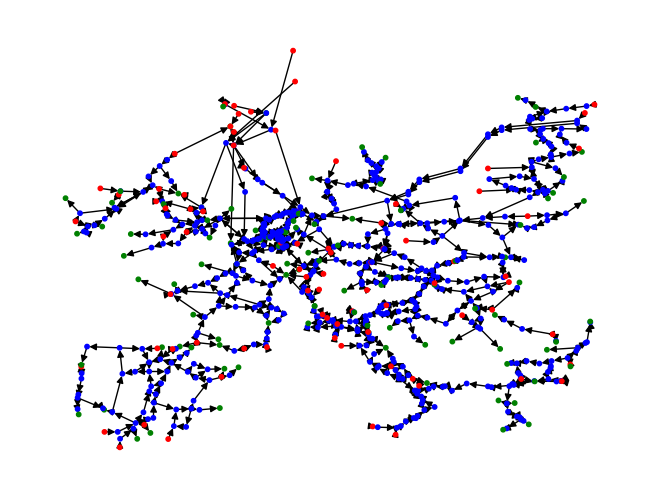

In [43]:
# Plot the G_largest graph. However, this time around, let nodes with in-degree 0 have a certain color, nodes with out-degree 0 have a certain color, and nodes with both in-degree and out-degree 0 have a certain color
in_degree = dict(G_simple_directed.in_degree())
out_degree = dict(G_simple_directed.out_degree())
node_colors = {node: 'blue' for node in G_simple_directed.nodes}
for node in G_simple_directed.nodes:
    if in_degree[node] == 0:
        node_colors[node] = 'red'
    if out_degree[node] == 0:
        node_colors[node] = 'green'
    if in_degree[node] == 0 and out_degree[node] == 0:
        node_colors[node] = 'yellow'

nx.draw(G_simple_directed, pos, with_labels=False, node_size=10, node_color=list(node_colors.values()))
plt.show()

In [44]:
# Solve the max-flow problem on the G_simple_directed graph

# Define the source and sink nodes, as the nodes with 0 in-degree and 0 out-degree, respectively
sources = [node for node in G_simple_directed.nodes if in_degree[node] == 0]
sinks = [node for node in G_simple_directed.nodes if out_degree[node] == 0]

# Solve the max-flow problem
def solve_MFMSS(graph, sources, sinks):
    
    # Create a copy of the graph with the same nodes, edges, and edge attributes
    graph_ = copy.deepcopy(graph)

    # Create a super-source and super-sink
    graph_.add_node('super_source')
    graph_.add_node('super_sink')

    # Add edges from the super-source to the sources and from the sinks to the super-sink
    for source in sources:
        graph_.add_edge('super_source', source, max_cap_M_m3_per_d=float('inf'))
    for sink in sinks:
        graph_.add_edge(sink, 'super_sink', max_cap_M_m3_per_d=float('inf'))
    
    # Return the solution to the max-flow problem
    return nx.maximum_flow(graph_, 'super_source', 'super_sink', capacity='max_cap_M_m3_per_d')

# Solve the max-flow problem
flow_value, flow_dict = solve_MFMSS(G_simple_directed, sources, sinks)

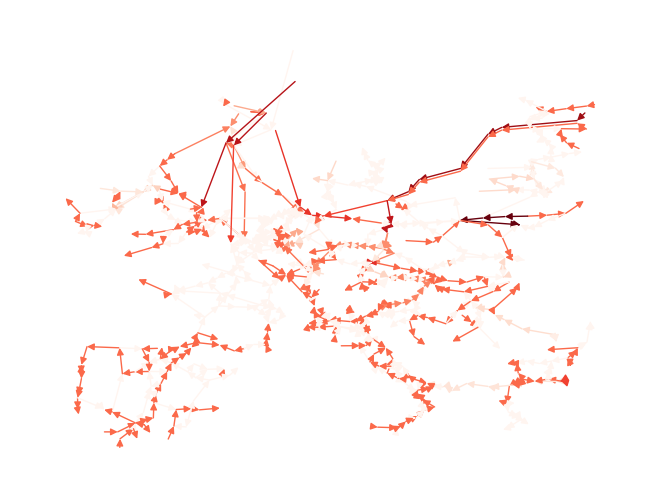

In [46]:
# Using the solution to the max-flow problem, create a new graph, coloring the edges with flow > 0 red, and the edges with flow = 0 blue, but omitting the edges from the super-source and to the super-sink
G_flow = nx.DiGraph()
for from_node in flow_dict:
    for to_node in flow_dict[from_node]:
        if from_node != 'super_source' and to_node != 'super_sink':
            if flow_dict[from_node][to_node] > 0:
                G_flow.add_edge(from_node, to_node, flow=flow_dict[from_node][to_node])
            else:
                G_flow.add_edge(from_node, to_node, flow=0)

# Plot the G_flow graph, but don't show the nodes. Color the edges in a heatmap according to the flow attribute
edge_colors = [G_flow[from_node][to_node]['flow'] for from_node, to_node in G_flow.edges]
nx.draw(G_flow, pos, with_labels=False, node_size=0, edge_color=edge_colors, edge_cmap=plt.cm.Reds)
plt.show()

## Ye et al. (2022): "Topology Analysis of Natural Gas Pipeline Networks Based on Complex Network Theory"

In [49]:
# Create an undirected graph from the G_multi_digraph graph
G_multi_graph = nx.Graph(G_multi_digraph)

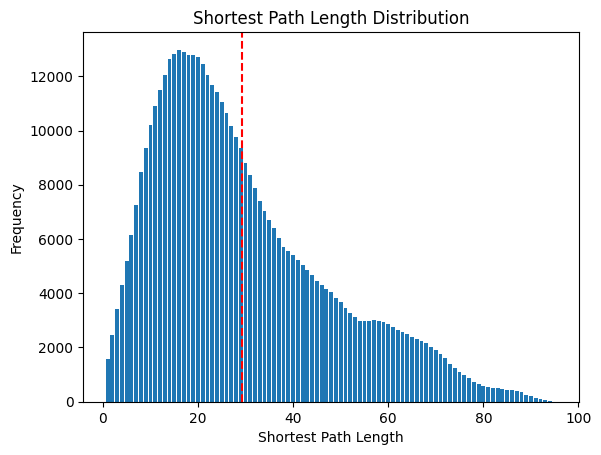

In [56]:
# Compute all pairs shortest path lengths
lengths = dict(nx.all_pairs_shortest_path_length(G_multi_graph))

# Flatten the dictionary to a list of lengths
all_lengths = [length for source in lengths for length in lengths[source].values()]

# Plot the distribution
plt.hist(all_lengths, bins=range(1, max(all_lengths) + 2), align='left', rwidth=0.8)

# Add a line for the average shortest path length
plt.axvline(x=nx.average_shortest_path_length(G_multi_graph), color='red', linestyle='dashed')
plt.xlabel('Shortest Path Length')
plt.ylabel('Frequency')
plt.title('Shortest Path Length Distribution')
plt.show()

In [55]:
# Compute the clustering coefficient of the G_multi_graph graph
clustering_coefficient = nx.average_clustering(G_multi_graph)
print('Clustering Coefficient:', clustering_coefficient)

Clustering Coefficient: 0.02133138969873664


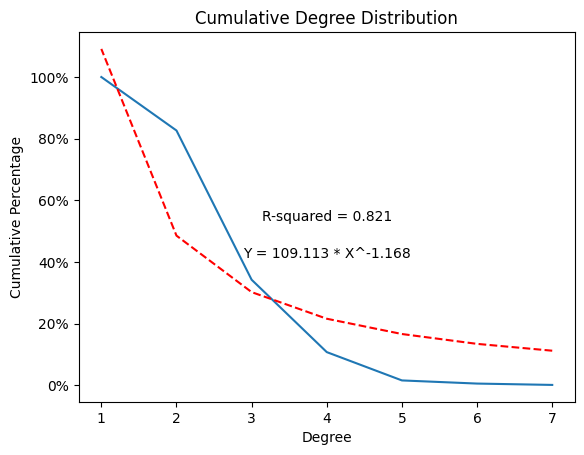

In [65]:
import matplotlib.ticker as mtick

# Plot the cumulative degree distribution curve of the G_multi_graph graph
degree_sequence = sorted([d for n, d in G_multi_graph.degree()], reverse=True)
degreeCount = dict()
for degree in degree_sequence:
    degreeCount[degree] = degreeCount.get(degree, 0) + 1
cumulative_degreeCount = {}
cumulative_count = 0
total_count = sum(degreeCount.values())  # Calculate the total count
for degree in degreeCount:
    cumulative_count += degreeCount[degree]
    cumulative_degreeCount[degree] = cumulative_count / total_count * 100  # Convert count to percentage
plt.plot(list(cumulative_degreeCount.keys()), list(cumulative_degreeCount.values()))
plt.xlabel('Degree')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Degree Distribution')

# Add percentage sign to y-axis
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

# Add a power law fit to the plot
import numpy as np
from scipy.optimize import curve_fit
x = np.array(list(cumulative_degreeCount.keys()))
y = np.array(list(cumulative_degreeCount.values()))
def power_law(x, a, b):
    return a * x ** b
popt, pcov = curve_fit(power_law, x, y)
plt.plot(x, power_law(x, *popt), 'r--', label='a=%5.3f, b=%5.3f' % tuple(popt))
# Compute the r-squared value
residuals = y - power_law(x, *popt)
ss_res = np.sum(residuals ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r_squared = 1 - (ss_res / ss_tot)
# Display the r-squared value
plt.text(0.5, 0.5, 'R-squared = %5.3f' % r_squared, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Display the definition of the power law function
plt.text(0.5, 0.4, 'Y = %5.3f * X^%5.3f' % tuple(popt), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()

In [68]:
# Compute the edge density, meshedness coefficient, edge per note ratio, center-point dominance, assortative coefficient, network diameter, algebraic connectivity and spectral gap of the G_multi_graph graph
edge_density = nx.density(G_multi_graph)
edge_per_node_ratio = G_multi_graph.number_of_edges() / G_multi_graph.number_of_nodes()
center_point_dominance = nx.center(G_multi_graph)
assortative_coefficient = nx.degree_assortativity_coefficient(G_multi_graph)
network_diameter = nx.diameter(G_multi_graph)
algebraic_connectivity = nx.algebraic_connectivity(G_multi_graph)
print('Edge Density:', edge_density)
print('Edge per Node Ratio:', edge_per_node_ratio)
print('Center Point Dominance:', center_point_dominance)
print('Assortative Coefficient:', assortative_coefficient)
print('Network Diameter:', network_diameter)
print('Algebraic Connectivity:', algebraic_connectivity)

Edge Density: 0.0033580898469919773
Edge per Node Ratio: 1.1501457725947521
Center Point Dominance: ['INET_N_561', 'INET_N_1609']
Assortative Coefficient: -0.03103006152512145
Network Diameter: 95
Algebraic Connectivity: 0.0005289409209610569


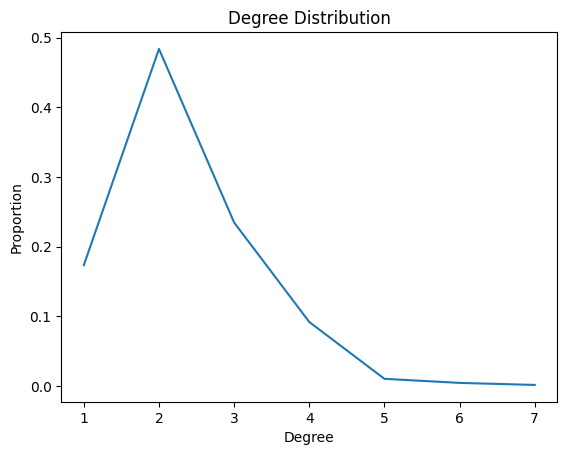

In [78]:
# Plot the degree distribution of the G_multi_graph graph as a curve
degree_sequence = sorted([d for n, d in G_multi_graph.degree()], reverse=True)
degreeCount = dict()
total_count = len(degree_sequence)  # Calculate the total count
for degree in degree_sequence:
    degreeCount[degree] = degreeCount.get(degree, 0) + 1
degreeProportion = {degree: count / total_count for degree, count in degreeCount.items()}

plt.plot(list(degreeProportion.keys()), list(degreeProportion.values()))
plt.xlabel('Degree')
plt.ylabel('Proportion')
plt.title('Degree Distribution')
plt.show()

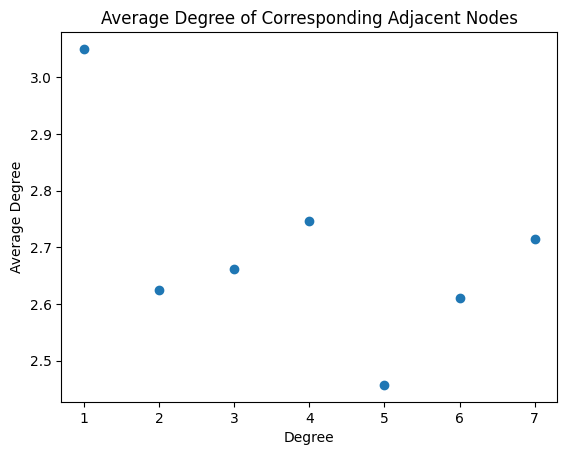

In [81]:
average_degree = nx.average_degree_connectivity(G_multi_graph)
plt.scatter(list(average_degree.keys()), list(average_degree.values()))
plt.xlabel('Degree')
plt.ylabel('Average Degree')
plt.title('Average Degree of Corresponding Adjacent Nodes')
plt.show()

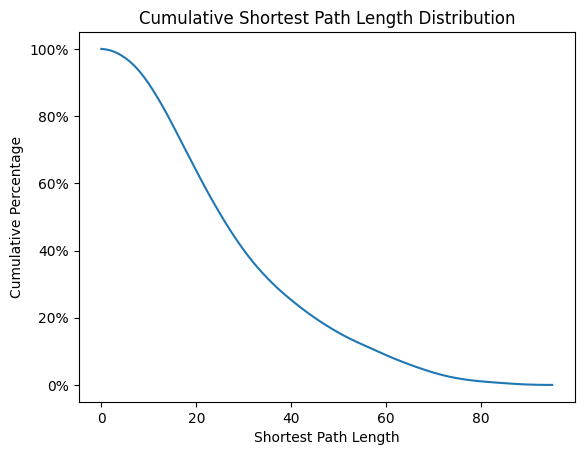

In [85]:
import matplotlib.ticker as mtick

# Plot the cumulative distribution probability of the shortest path lengths of the G_multi_graph graph
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G_multi_graph))
shortest_path_lengths = [length for source in shortest_path_lengths for length in shortest_path_lengths[source].values()]
shortest_path_lengths = sorted(shortest_path_lengths, reverse=True)
shortest_path_lengths_count = dict()
for length in shortest_path_lengths:
    shortest_path_lengths_count[length] = shortest_path_lengths_count.get(length, 0) + 1
cumulative_shortest_path_lengths_count = {}
cumulative_count = 0
total_count = sum(shortest_path_lengths_count.values())  # Calculate the total count
for length in shortest_path_lengths_count:
    cumulative_count += shortest_path_lengths_count[length]
    cumulative_shortest_path_lengths_count[length] = cumulative_count / total_count * 100  # Convert count to percentage
plt.plot(list(cumulative_shortest_path_lengths_count.keys()), list(cumulative_shortest_path_lengths_count.values()))
plt.xlabel('Shortest Path Length')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Shortest Path Length Distribution')
# Add percentage sign to y-axis
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()